# Diagnostic model
Name: Diagnostic8\
Velocity: calving\
fluidity: pre-calving\
Geometry: calving\
Rift: calving\
Temperature: 253

In [1]:
import icepack
import geojson
import numpy as np
import icepack.plot
import rasterio
from rasterio.plot import show
import firedrake
import xarray
from firedrake import assemble, Constant, inner, grad, dx, sym, sqrt, tr, ds
import matplotlib.pyplot as plt
import pickle
import math
from rasterio.crs import CRS
from rasterio.transform import from_origin
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
with open("/home/sermilik/brunt_model/output_extraction_locations.pkl", "rb") as f1:
    extraction_locations = pickle.load(f1)

f1.close()

#perpendicular angles
west_angle = extraction_locations["west_angle"]
east_angle = extraction_locations["east_angle"]
#extraction points
w_n_x_2020 = extraction_locations["w_n_x_calv"]
w_n_y_2020 = extraction_locations["w_n_y_calv"]
w_s_x_2020 = extraction_locations["w_s_x_calv"]
w_s_y_2020 = extraction_locations["w_s_y_calv"]
e_n_x_2020 = extraction_locations["e_n_x_calv"]
e_n_y_2020 = extraction_locations["e_n_y_calv"]
e_s_x_2020 = extraction_locations["e_s_x_calv"]
e_s_y_2020 = extraction_locations["e_s_y_calv"]


### Geometry

In [3]:
outline = '/home/sermilik/brunt_model/Diagnostic/geojson/brunt_HC_2021_calving.geojson'

with open(outline,"r") as outline_file:
    outline = geojson.load(outline_file)
    
print(outline["crs"]["properties"]["name"])

urn:ogc:def:crs:EPSG::3031


In [4]:
δ = 50e3
coords = np.array(list(geojson.utils.coords(outline)))
xmin, xmax = coords[:, 0].min() - δ, coords[:, 0].max() + δ
ymin, ymax = coords[:, 1].min() - δ, coords[:, 1].max() + δ

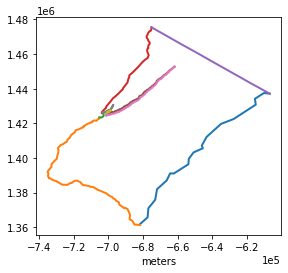

In [5]:
fig, axes = icepack.plot.subplots()

for feature in outline["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel("meters");

### Imagery

In [6]:
image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
image_file = rasterio.open(image_filename, "r")

transform = image_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax, transform=transform
)

image = image_file.read(indexes=1, window=window, masked=True)

In [7]:
def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    extent = (xmin, xmax, ymin, ymax)
    axes.imshow(
        image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent
    )

    return fig, axes

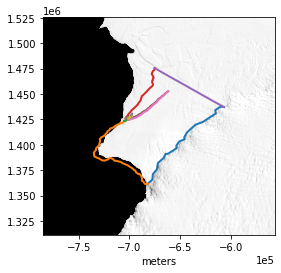

In [8]:
fig, axes = subplots()

for feature in outline["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel("meters");

### Meshing

In [9]:
geometry = icepack.meshing.collection_to_geo(outline)

with open("brunt_diag.geo", "w") as geo_file:
    geo_file.write(geometry.get_code())

!gmsh -2 -format msh2 -v 2 -o brunt_diag.msh brunt_diag.geo    
    
mesh = firedrake.Mesh("brunt_diag.msh") 

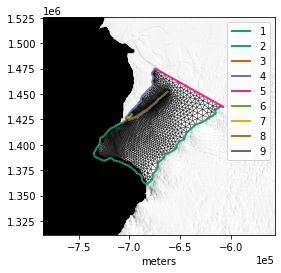

In [10]:
fig, axes = subplots()
axes.set_xlabel("meters")
kwargs = {
    "interior_kw": {"linewidth": 0.25},
    "boundary_kw": {"linewidth": 2},
}
icepack.plot.triplot(mesh, axes=axes, **kwargs)
axes.legend();

### Input data - thickness

In [11]:
thickness_filename = '/home/sermilik/brunt_model/thickness_brunt_fullcalc.tif'
thickness = rasterio.open(thickness_filename,"r")

Q = firedrake.FunctionSpace(mesh, "CG", 2)
h0 = icepack.interpolate(thickness, Q)



In [12]:
h = h0.copy(deepcopy=True)
α = firedrake.Constant(2e3)
J = 0.5 * (h - h0)**2 * dx + 0.5 * α**2 * inner(grad(h), grad(h)) * dx
F = firedrake.derivative(J, h)
firedrake.solve(F == 0, h)

### Input data - velocity

In [13]:
velocity_filename_vx = '/home/sermilik/brunt_model/Diagnostic/interp/model_velocity_vx_calving_err5_T253_steptol_1Eneg2_interp.tif'
velocity_filename_vy = '/home/sermilik/brunt_model/Diagnostic/interp/model_velocity_vy_calving_err5_T253_steptol_1Eneg2_interp.tif'

vx = rasterio.open(velocity_filename_vx, "r")
vy = rasterio.open(velocity_filename_vy, "r")

V = firedrake.VectorFunctionSpace(mesh, "CG", 2)
u0 = icepack.interpolate((vx, vy), V)


### Input data - fluidity

In [14]:
fluid_filename = '/home/sermilik/brunt_model/Diagnostic/interp/fluidity_pre_calving_err5_T253_steptol_1Eneg2_interp.tif'
fluid = rasterio.open(fluid_filename,"r")

θ = icepack.interpolate(fluid, Q)

### Modeling

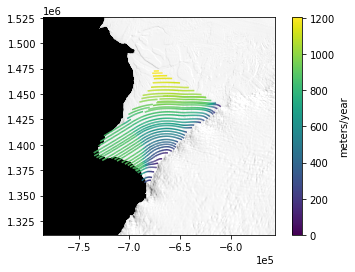

In [15]:
fig, axes = subplots()
streamlines = icepack.plot.streamplot(
    u0, precision=1000, density=2500, axes=axes
)
fig.colorbar(streamlines, label="meters/year");

In [16]:
T = Constant(253) #253
A0 = icepack.rate_factor(T)

def viscosity(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    θ = kwargs["log_fluidity"]

    A = A0 * firedrake.exp(θ)
    return icepack.models.viscosity.viscosity_depth_averaged(
        velocity=u, thickness=h, fluidity=A
    )


model = icepack.models.IceShelf(viscosity=viscosity)
opts = {
    "dirichlet_ids": [1, 3, 5],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)


In [17]:
def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u0,
        thickness=h,
        log_fluidity=θ,
    )

u = simulation(θ)

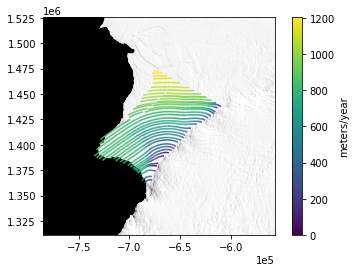

In [18]:
fig, axes = subplots()
streamlines = icepack.plot.streamplot(
    u, precision=1000, density=2500, axes=axes
)
fig.colorbar(streamlines, label="meters/year");

In [19]:
#model extract
vw_n_2020 = u((w_n_x_2020,w_n_y_2020))
vw_s_2020 = u((w_s_x_2020,w_s_y_2020))
ve_n_2020 = u((e_n_x_2020,e_n_y_2020))
ve_s_2020 = u((e_s_x_2020,e_s_y_2020))

#model magnitude
vw_n_2020_tot = np.sqrt((vw_n_2020[0]**2)+(vw_n_2020[1]**2))
vw_s_2020_tot = np.sqrt((vw_s_2020[0]**2)+(vw_s_2020[1]**2))
ve_n_2020_tot = np.sqrt((ve_n_2020[0]**2)+(ve_n_2020[1]**2))
ve_s_2020_tot = np.sqrt((ve_s_2020[0]**2)+(ve_s_2020[1]**2))

#model angle
vw_n_2020_angle = (math.atan(vw_n_2020[1]/vw_n_2020[0]))
vw_s_2020_angle = (math.atan(vw_s_2020[1]/vw_s_2020[0]))
ve_n_2020_angle = (math.atan(ve_n_2020[1]/ve_n_2020[0]))
ve_s_2020_angle = (math.atan(ve_s_2020[1]/ve_s_2020[0]))

#model offset to rift perp
vw_n_2020_offset = abs(-90-math.degrees(vw_n_2020_angle) - math.degrees(west_angle))
vw_s_2020_offset = abs(-90-math.degrees(vw_s_2020_angle) - math.degrees(west_angle))
ve_n_2020_offset = abs(-90-math.degrees(ve_n_2020_angle) - math.degrees(east_angle))
ve_s_2020_offset = abs(-90-math.degrees(ve_s_2020_angle) - math.degrees(east_angle))

#model rift perp
vw_n_2020_perp = vw_n_2020_tot * math.cos(math.radians(vw_n_2020_offset))
vw_s_2020_perp = vw_s_2020_tot * math.cos(math.radians(vw_s_2020_offset))
ve_n_2020_perp = ve_n_2020_tot * math.cos(math.radians(ve_n_2020_offset))
ve_s_2020_perp = ve_s_2020_tot * math.cos(math.radians(ve_s_2020_offset))

#model rift para
vw_n_2020_para = vw_n_2020_tot * math.sin(math.radians(vw_n_2020_offset))
vw_s_2020_para = vw_s_2020_tot * math.sin(math.radians(vw_s_2020_offset))
ve_n_2020_para = ve_n_2020_tot * math.sin(math.radians(ve_n_2020_offset))
ve_s_2020_para = ve_s_2020_tot * math.sin(math.radians(ve_s_2020_offset))

#model difference across rift
#model open
vdiffw_2020 = vw_n_2020_perp - vw_s_2020_perp
vdiffe_2020 = ve_n_2020_perp - ve_s_2020_perp
#model shear
vshearw_2020 = vw_n_2020_para - vw_s_2020_para
vsheare_2020 = ve_n_2020_para - ve_s_2020_para



In [20]:
print("west,  seaward v_total: "+str(round(vw_n_2020_tot,1))+" m/yr")
print("west, landward v_total: "+str(round(vw_s_2020_tot,1))+" m/yr")
print("east,  seaward v_total: "+str(round(ve_n_2020_tot,1))+" m/yr")
print("east, landward v_total: "+str(round(ve_s_2020_tot,1))+" m/yr")
print("")
print("west,   seaward v_perp: "+str(round(vw_n_2020_perp,1))+" m/yr")
print("west,  landward v_perp: "+str(round(vw_s_2020_perp,1))+" m/yr")
print("east,   seaward v_perp: "+str(round(ve_n_2020_perp,1))+" m/yr")
print("east,  landward v_perp: "+str(round(ve_s_2020_perp,1))+" m/yr")
print("")
print("west,   seaward v_para: "+str(round(vw_n_2020_para,1))+" m/yr")
print("west,  landward v_para: "+str(round(vw_s_2020_para,1))+" m/yr")
print("east,   seaward v_para: "+str(round(ve_n_2020_para,1))+" m/yr")
print("east,  landward v_para: "+str(round(ve_s_2020_para,1))+" m/yr")


west,  seaward v_total: 837.5 m/yr
west, landward v_total: 868.7 m/yr
east,  seaward v_total: 963.6 m/yr
east, landward v_total: 958.5 m/yr

west,   seaward v_perp: 250.6 m/yr
west,  landward v_perp: 183.9 m/yr
east,   seaward v_perp: 513.5 m/yr
east,  landward v_perp: 457.7 m/yr

west,   seaward v_para: 799.1 m/yr
west,  landward v_para: 849.0 m/yr
east,   seaward v_para: 815.3 m/yr
east,  landward v_para: 842.2 m/yr


In [21]:
print("------------------------------")
print("Model    : Diagnostic 8")
print("Velocity : calving model")
print("Fluidity : Pre-calving model")
print("Geometry : calving")
print("Rift     : calving")
print("Temp     : 253")
print("")
print("Opening rates: model")
print("Western opening rate:  "+str(round(vdiffw_2020,1))+" m/yr")
print("Eastern opening rate:  "+str(round(vdiffe_2020,1))+" m/yr")
print("")
print("Western shear rate: "+str(round(vshearw_2020,1))+" m/yr")
print("Eastern shear rate: "+str(round(vsheare_2020,1))+" m/yr")




------------------------------
Model    : Diagnostic 8
Velocity : calving model
Fluidity : Pre-calving model
Geometry : calving
Rift     : calving
Temp     : 253

Opening rates: model
Western opening rate:  66.7 m/yr
Eastern opening rate:  55.8 m/yr

Western shear rate: -49.9 m/yr
Eastern shear rate: -26.8 m/yr
